In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- CONFIGURAZIONE ---
FILE_NAME = 'report_unito_ordinato.csv'
LATITUDE = 44.77   # Correggio
LONGITUDE = 10.78  # Correggio

# 1. Caricamento dati produzione
print("Caricamento dati produzione...")
df_energy = pd.read_csv(FILE_NAME)
df_energy['Date'] = pd.to_datetime(df_energy['Date'])

print(df_energy.head())

# 1. Definisci le colonne che *vuoi* mantenere
colonne_da_mantenere = ['Date', 'Daily Production (Active)']

# 2. Identifica le colonne che *non* vuoi mantenere
colonne_da_rimuovere = [
    col for col in df_energy.columns
    if col not in colonne_da_mantenere
]

# 3. Rimuovi le colonne indesiderate dal DataFrame
# axis=1 specifica che l'operazione è sulle colonne
df_energy.drop(columns=colonne_da_rimuovere, inplace=True)

print(f"Rimosse {len(colonne_da_rimuovere)} colonne.")
print(f"Colonnes rimaste: {df_energy.columns.tolist()}")
print(df_energy.head())

# Otteniamo il range di date dal file
start_date = df_energy['Date'].min().strftime('%Y-%m-%d')
end_date = df_energy['Date'].max().strftime('%Y-%m-%d')
print(f"Periodo individuato: {start_date} - {end_date}")

# 2. Download dati meteo (Open-Meteo API)
print("Scaricamento dati meteo da Open-Meteo...")
# Usiamo l'endpoint 'archive' per dati storici o 'forecast' con past_days se molto recenti.
# Qui usiamo la richiesta standard che copre il range date.
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": LATITUDE,
    "longitude": LONGITUDE,
    "start_date": start_date,
    "end_date": end_date,
    # Variabili chiave per il fotovoltaico: Radiazione Solare, Temperatura (Max/Min), Precipitazioni
    "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,shortwave_radiation_sum",
    "timezone": "auto"
}

response = requests.get(url, params=params)
if response.status_code != 200:
    raise Exception("Errore nel scaricare i dati meteo: " + response.text)

weather_json = response.json()

# Creazione DataFrame Meteo
daily_data = weather_json['daily']
df_weather = pd.DataFrame({
    'Date': pd.to_datetime(daily_data['time']),
    'solar_radiation': daily_data['shortwave_radiation_sum'], # Fattore più importante
    'temp_max': daily_data['temperature_2m_max'],
    'temp_min': daily_data['temperature_2m_min'],
    'precipitation': daily_data['precipitation_sum']
})

# 3. Unione dei dati (Merge)
print("Unione dataset...")
df_final = pd.merge(df_energy, df_weather, on='Date', how='inner')

# Rimuoviamo eventuali righe con dati mancanti
df_final = df_final.dropna()
# Assumendo che il nome della colonna sia 'Daily'
indici_massimi = df_final.groupby('Date')['Daily Production (Active)'].idxmax()

# Seleziona le righe corrispondenti agli indici massimi
df = df_final.loc[indici_massimi]

# 4. Preparazione Machine Learning
# X = Features (Meteo), y = Target (Produzione)

X = df[['solar_radiation', 'temp_max', 'temp_min', 'precipitation']]
y = df['Daily Production (Active)']
df.head(5)



Caricamento dati produzione...
        Date                Serial            Timestamp  Timezone  \
0 2025-09-29  ZH1025006KE24A1700R7  2025-09-29 11:45:51         8   
1 2025-09-29  ZH1025006KE24A1700R7  2025-09-29 11:46:19         8   
2 2025-09-29  ZH1025006KE24A1700R7  2025-09-29 11:52:02         8   
3 2025-09-29  ZH1025006KE24A1700R7  2025-09-29 11:57:06         8   
4 2025-09-29  ZH1025006KE24A1700R7  2025-09-29 12:02:09         8   

   AC Voltage R  AC Current R  Grid Frequency  Power Battery Pack 1  \
0         237.7          0.02           49.99                   230   
1         237.7          0.02           49.99                   230   
2         237.8          1.30           50.03                    20   
3         239.4          1.38           49.99                  1710   
4         236.8          0.86           50.02                  1170   

   Power Battery Pack 2  Total Grid Power  ...  Daily Consumption  \
0                     0                 0  ...            

,Date,Daily Production (Active),solar_radiation,temp_max,temp_min,precipitation
86,2025-09-29,4.56,16.46,23.4,10.8,0.0
380,2025-09-30,7.40,13.65,22.2,9.8,0.0
635,2025-10-01,2.61,10.77,19.7,12.7,4.3
921,2025-10-02,6.38,14.27,18.5,8.7,0.0
1201,2025-10-03,14.32,15.70,18.8,6.8,0.0


In [2]:
X.head(5)

,solar_radiation,temp_max,temp_min,precipitation
86,16.46,23.4,10.8,0.0
380,13.65,22.2,9.8,0.0
635,10.77,19.7,12.7,4.3
921,14.27,18.5,8.7,0.0
1201,15.70,18.8,6.8,0.0


In [3]:
y.head(5)

86       4.56
380      7.40
635      2.61
921      6.38
1201    14.32
Name: Daily Production (Active), dtype: float64

Allenamento modello in corso...

--- RISULTATI MODELLO ---
Errore Medio Assoluto (MAE): 2.79 kWh
R2 Score (Precisione 0-1): 0.70

--- IMPORTANZA VARIABILI ---
solar_radiation    0.589168
temp_min           0.227990
precipitation      0.111220
temp_max           0.071622
dtype: float64


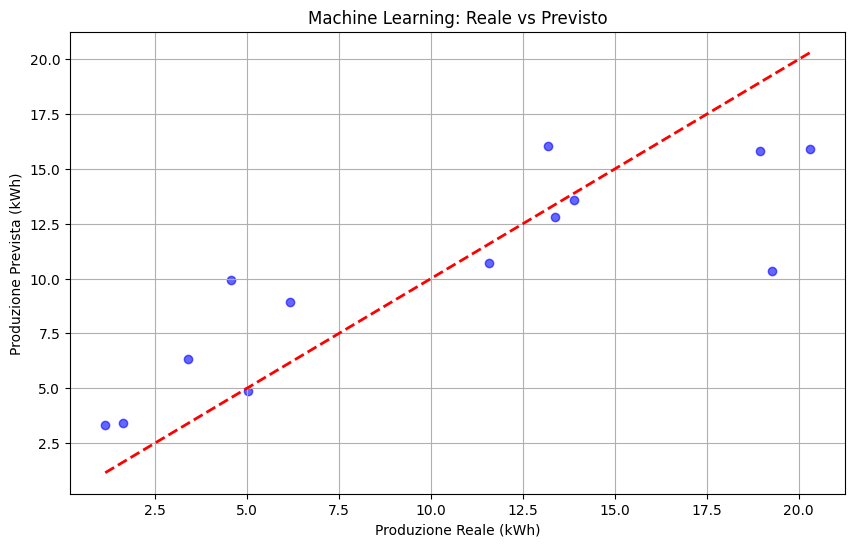


Il modello è pronto. Per prevedere il futuro, scarica le previsioni meteo e passale al metodo `model.predict()`.


In [4]:

# Divisione Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Allenamento Modello
print("Allenamento modello in corso...")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6. Valutazione
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- RISULTATI MODELLO ---")
print(f"Errore Medio Assoluto (MAE): {mae:.2f} kWh")
print(f"R2 Score (Precisione 0-1): {r2:.2f}")

# Esempio di previsione
print("\n--- IMPORTANZA VARIABILI ---")
importances = pd.Series(model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

# Grafico Previsione vs Reale
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Produzione Reale (kWh)')
plt.ylabel('Produzione Prevista (kWh)')
plt.title('Machine Learning: Reale vs Previsto')
plt.grid(True)
plt.show()

print("\nIl modello è pronto. Per prevedere il futuro, scarica le previsioni meteo e passale al metodo `model.predict()`.")

In [5]:
import pandas as pd
import requests
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from datetime import date, timedelta

# --- CONFIGURAZIONE ---
FILE_DATI = 'report_unito_ordinato.csv'
LATITUDE = 44.77   # Correggio
LONGITUDE = 10.78  # Correggio

def get_weather_data(start_date, end_date, is_forecast=False):
    """Scarica dati meteo (storici o previsioni) da Open-Meteo"""

    url = "https://api.open-meteo.com/v1/forecast"

    params = {
        "latitude": LATITUDE,
        "longitude": LONGITUDE,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,shortwave_radiation_sum",
        "timezone": "auto"
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"Errore API Meteo: {response.text}")

    data = response.json()['daily']

    df = pd.DataFrame({
        'Date': pd.to_datetime(data['time']),
        'solar_radiation': data['shortwave_radiation_sum'],
        'temp_max': data['temperature_2m_max'],
        'temp_min': data['temperature_2m_min'],
        'precipitation': data['precipitation_sum']
    })
    return df

def main():
    print("--- 1. ADDESTRAMENTO DEL MODELLO ---")

    # 1. Carica, pulisci e prepara i dati energia
    try:
        # Carica il CSV utilizzando la codifica 'latin-1' per evitare l'errore Unicode
        df_energy = pd.read_csv(FILE_DATI, encoding='latin-1')
        df_energy['Date'] = pd.to_datetime(df_energy['Date'])
    except FileNotFoundError:
        print(f"Errore: Non trovo il file '{FILE_DATI}'. Assicurati di averlo creato prima.")
        return

    # Seleziona solo le colonne necessarie
    colonne_da_mantenere = ['Date', 'Daily Production (Active)']
    df_energy = df_energy[colonne_da_mantenere]

    # MANTIENI LA RIGA CON LA PRODUZIONE MASSIMA PER OGNI DATA (LA LOGICA CORRETTA)
    indici_massimi = df_energy.groupby('Date')['Daily Production (Active)'].idxmax()
    df_energy = df_energy.loc[indici_massimi]

    # Rimuovi eventuali righe finali con dati mancanti (dopo la pulizia)
    df_energy.dropna(inplace=True)


    # 2. Scarica meteo storico per il periodo dei dati
    start_hist = df_energy['Date'].min().strftime('%Y-%m-%d')
    end_hist = df_energy['Date'].max().strftime('%Y-%m-%d')
    print(f"Scarico meteo storico ({start_hist} - {end_hist})...")

    df_weather_hist = get_weather_data(start_hist, end_hist)

    # 3. Unisci e allena
    # Il DataFrame df_energy è già pulito e filtrato, quindi non ha più righe doppie
    df_train = pd.merge(df_energy, df_weather_hist, on='Date')
    # Rimuovo dropna() dopo il merge, perché i dati sono già stati puliti in precedenza

    X_train = df_train[['solar_radiation', 'temp_max', 'temp_min', 'precipitation']]
    y_train = df_train['Daily Production (Active)']

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    print("Modello addestrato con successo!")

    print("\n--- 2. SIMULAZIONE PER IL FUTURO ---")

    # 4. Calcola la data per la quale vuoi la previsione (due giorni dopo oggi, come nel tuo codice)
    today = date.today()
    giorno_previsione = today + timedelta(days=2)
    giorno_previsione_str = giorno_previsione.strftime('%Y-%m-%d')

    print(f"Scarico previsioni meteo per il {giorno_previsione_str}...")

    # 5. Scarica previsioni
    df_forecast = get_weather_data(giorno_previsione_str, giorno_previsione_str, is_forecast=True)

    if df_forecast.isnull().values.any():
        print("Attenzione: Alcuni dati meteo mancano (es. radiazione solare). Riempio con 0.")
        df_forecast = df_forecast.fillna(0)

    # 6. Prevedi
    X_forecast = df_forecast[['solar_radiation', 'temp_max', 'temp_min', 'precipitation']]
    prediction = model.predict(X_forecast)[0]

    # Stampa dettagli
    meteo = X_forecast.iloc[0]
    print("-" * 30)
    print(f"DATA: {giorno_previsione_str}")
    print(f"Meteo Previsto a Correggio:")
    print(f"  - Radiazione Solare: {meteo['solar_radiation']:.2f} MJ/m²")
    print(f"  - Temperatura: {meteo['temp_min']:.1f}°C / {meteo['temp_max']:.1f}°C")
    print(f"  - Pioggia: {meteo['precipitation']:.2f} mm")
    print("-" * 30)
    print(f"PRODUZIONE STIMATA: {prediction:.2f} kWh")
    print("-" * 30)

if __name__ == "__main__":
    main()

--- 1. ADDESTRAMENTO DEL MODELLO ---
Scarico meteo storico (2025-09-29 - 2025-11-29)...
Modello addestrato con successo!

--- 2. SIMULAZIONE PER IL FUTURO ---
Scarico previsioni meteo per il 2025-12-07...
------------------------------
DATA: 2025-12-07
Meteo Previsto a Correggio:
  - Radiazione Solare: 2.49 MJ/m²
  - Temperatura: 4.5°C / 6.5°C
  - Pioggia: 0.00 mm
------------------------------
PRODUZIONE STIMATA: 4.03 kWh
------------------------------


In [6]:
import pandas as pd
import requests
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from datetime import date, timedelta

# --- CONFIGURAZIONE ---
FILE_DATI = 'report_unito_ordinato.csv'
LATITUDE = 44.77   # Correggio
LONGITUDE = 10.78  # Correggio

def get_weather_data(start_date, end_date, is_forecast=False):
    """Scarica dati meteo (storici o previsioni) da Open-Meteo"""

    # Se chiediamo previsioni future, usiamo l'endpoint forecast standard.
    # Se chiediamo dati passati, l'endpoint forecast funziona comunque per il passato recente,
    # ma per dati molto vecchi servirebbe 'archive'. Qui usiamo 'forecast' che copre entrambi per semplicità.
    url = "https://api.open-meteo.com/v1/forecast"

    params = {
        "latitude": LATITUDE,
        "longitude": LONGITUDE,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,shortwave_radiation_sum",
        "timezone": "auto"
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"Errore API Meteo: {response.text}")

    data = response.json()['daily']

    df = pd.DataFrame({
        'Date': pd.to_datetime(data['time']),
        'solar_radiation': data['shortwave_radiation_sum'],
        'temp_max': data['temperature_2m_max'],
        'temp_min': data['temperature_2m_min'],
        'precipitation': data['precipitation_sum']
    })
    return df

def main():
    print("--- 1. ADDESTRAMENTO DEL MODELLO ---")
    # 1. Carica dati energia
    try:
        df_energy = pd.read_csv(FILE_DATI)
        df_energy['Date'] = pd.to_datetime(df_energy['Date'])
    except FileNotFoundError:
        print(f"Errore: Non trovo il file '{FILE_DATI}'. Assicurati di averlo creato prima.")
        return

    # 2. Scarica meteo storico per il periodo dei dati
    start_hist = df_energy['Date'].min().strftime('%Y-%m-%d')
    end_hist = df_energy['Date'].max().strftime('%Y-%m-%d')
    print(f"Scarico meteo storico ({start_hist} - {end_hist})...")

    df_weather_hist = get_weather_data(start_hist, end_hist)

    # 3. Unisci e allena
    df_train = pd.merge(df_energy, df_weather_hist, on='Date').dropna()

    X_train = df_train[['solar_radiation', 'temp_max', 'temp_min', 'precipitation']]
    y_train = df_train['Daily Production (Active)']

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    print("Modello addestrato con successo!")

    print("\n--- 2. SIMULAZIONE PER DOMANI ---")
    # 4. Calcola la data di domani
    today = date.today()
    tomorrow = today + timedelta(days=2)
    tomorrow_str = tomorrow.strftime('%Y-%m-%d')

    print(f"Scarico previsioni meteo per domani ({tomorrow_str})...")

    # 5. Scarica previsioni per domani
    # Nota: Le previsioni potrebbero essere nulle se l'API non ha ancora i dati per troppi giorni avanti,
    # ma per 'domani' sono sempre disponibili.
    df_forecast = get_weather_data(tomorrow_str, tomorrow_str, is_forecast=True)

    if df_forecast.isnull().values.any():
        print("Attenzione: Alcuni dati meteo per domani mancano (es. radiazione solare nulla).")
        # A volte la radiazione futura è null se troppo in là nel tempo o di notte
        df_forecast = df_forecast.fillna(0)

    # 6. Prevedi
    X_tomorrow = df_forecast[['solar_radiation', 'temp_max', 'temp_min', 'precipitation']]
    prediction = model.predict(X_tomorrow)[0]

    # Stampa dettagli
    meteo = X_tomorrow.iloc[0]
    print("-" * 30)
    print(f"DATA: {tomorrow_str}")
    print(f"Meteo Previsto a Correggio:")
    print(f"  - Radiazione Solare: {meteo['solar_radiation']} MJ/m²")
    print(f"  - Temperatura: {meteo['temp_min']}°C / {meteo['temp_max']}°C")
    print(f"  - Pioggia: {meteo['precipitation']} mm")
    print("-" * 30)
    print(f"PRODUZIONE STIMATA: {prediction:.2f} kWh")
    print("-" * 30)

if __name__ == "__main__":
    main()

--- 1. ADDESTRAMENTO DEL MODELLO ---
Scarico meteo storico (2025-09-29 - 2025-11-29)...


ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by RandomForestRegressor.

In [9]:
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import date, timedelta
import numpy as np
import joblib

# --- CONFIGURAZIONE ---
FILE_DATI = 'report-aggregate-2025-11-24_2.xlsx'
LATITUDE = 44.77   # Correggio
LONGITUDE = 10.78  # Correggio
EPOCHS = 1000      # Numero di volte che la rete vede i dati
LEARNING_RATE = 0.01

# --- 1. DEFINIZIONE DELLA RETE NEURALE ---
class SolarPredictor(nn.Module):
    def __init__(self, input_dim):
        super(SolarPredictor, self).__init__()
        # Architettura semplice: Input -> 16 Neuroni -> 8 Neuroni -> Output
        self.layer1 = nn.Linear(input_dim, 16)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(16, 8)
        self.layer3 = nn.Linear(8, 1) # Output: 1 valore (kWh)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

# --- FUNZIONI UTILI ---
def get_weather_data(start_date, end_date, is_forecast=False):
    """Scarica dati meteo da Open-Meteo"""
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": LATITUDE,
        "longitude": LONGITUDE,
        "start_date": start_date,
        "end_date": end_date,
        "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,shortwave_radiation_sum",
        "timezone": "auto"
    }
    response = requests.get(url, params=params)
    data = response.json()['daily']
    return pd.DataFrame({
        'Date': pd.to_datetime(data['time']),
        'solar_radiation': data['shortwave_radiation_sum'],
        'temp_max': data['temperature_2m_max'],
        'temp_min': data['temperature_2m_min'],
        'precipitation': data['precipitation_sum']
    }).fillna(0)

def main():
    # --- 2. PREPARAZIONE DATI ---
    print("--- CARICAMENTO E PREPARAZIONE DATI ---")

    # Caricamento CSV Locale
    try:
        df_energy = pd.read_excel(FILE_DATI)
        df_energy['Date'] = pd.to_datetime(df_energy['Date'])
    except FileNotFoundError:
        print(f"Errore: Manca il file '{FILE_DATI}'")
        return

    # Download Storico Meteo
    start_hist = df_energy['Date'].min().strftime('%Y-%m-%d')
    end_hist = df_energy['Date'].max().strftime('%Y-%m-%d')
    print(f"Scaricamento meteo storico ({start_hist} - {end_hist})...")
    df_weather = get_weather_data(start_hist, end_hist)

    # Merge
    df_final = pd.merge(df_energy, df_weather, on='Date').dropna()

    # Selezione Features (X) e Target (y)
    features = ['solar_radiation', 'temp_max', 'temp_min', 'precipitation']
    X = df_final[features].values
    y = df_final['Daily Production (kwh)'].values.reshape(-1, 1) # Reshape per PyTorch

    # Divisione Train/Test
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # NORMALIZZAZIONE (Fondamentale per Deep Learning!)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw) # Fit solo sul train
    X_test = scaler.transform(X_test_raw)       # Transform sul test

    # Conversione in Tensori PyTorch
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # --- 3. ADDESTRAMENTO (TRAINING LOOP) ---
    print(f"\n--- INIZIO ADDESTRAMENTO ({EPOCHS} epoche) ---")
    model = SolarPredictor(input_dim=4)
    criterion = nn.MSELoss() # Mean Squared Error
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    model.train() # Modalità addestramento
    for epoch in range(EPOCHS):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward pass e ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f'Epoca [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

    # --- 4. VALUTAZIONE ---
    model.eval() # Modalità valutazione
    with torch.no_grad():
        predictions = model(X_test_tensor)
        test_loss = criterion(predictions, y_test_tensor)
    print(f"\nTest Loss (MSE): {test_loss.item():.4f}")

    # --- 5. SIMULAZIONE DOMANI ---
    print("\n--- PREVISIONE PER DOMANI ---")
    today = date.today()
    tomorrow = today + timedelta(days=1)
    tomorrow_str = tomorrow.strftime('%Y-%m-%d')

    print(f"Scaricamento previsioni per {tomorrow_str}...")
    df_forecast = get_weather_data(tomorrow_str, tomorrow_str, is_forecast=True)

    # Preparazione input domani
    X_tomorrow_raw = df_forecast[features].values

    # IMPORTANTE: Usiamo lo stesso scaler usato per l'addestramento!
    X_tomorrow_scaled = scaler.transform(X_tomorrow_raw)
    X_tomorrow_tensor = torch.tensor(X_tomorrow_scaled, dtype=torch.float32)

    # Previsione
    model.eval()
    with torch.no_grad():
        pred_tomorrow = model(X_tomorrow_tensor)
        kwh_previsti = pred_tomorrow.item()

    # Stampa risultati
    meteo = df_forecast.iloc[0]
    print("-" * 30)
    print(f"Meteo previsto: Radiazione {meteo['solar_radiation']} MJ/m², Temp Max {meteo['temp_max']}°C")
    # Se la rete predice negativo (possibile se non allenata bene), mettiamo 0
    print(f"PRODUZIONE STIMATA: {max(0, kwh_previsti):.2f} kWh")
    print("-" * 30)

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'torch'

In [10]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import date, timedelta
import numpy as np
import joblib
# --- CONFIGURAZIONE ---
FILE_DATI = 'report-aggregate-2025-11-24_2.xlsx'
LATITUDE = 44.77   # Correggio
LONGITUDE = 10.78  # Correggio

# Aggiungiamo le nuove variabili qui
METEO_PARAMS = (
    "temperature_2m_max,temperature_2m_min,"
    "precipitation_sum,shortwave_radiation_sum,"
    "wind_speed_10m_max,cloud_cover_mean,daylight_duration,snowfall_sum"
)

def get_weather_data(start_date, end_date, is_forecast=False):
    """Scarica dati meteo estesi da Open-Meteo"""
    url = "https://api.open-meteo.com/v1/forecast"

    params = {
        "latitude": LATITUDE,
        "longitude": LONGITUDE,
        "start_date": start_date,
        "end_date": end_date,
        "daily": METEO_PARAMS,
        "timezone": "auto"
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"Errore API Meteo: {response.text}")

    data = response.json()['daily']

    df = pd.DataFrame({
        'Date': pd.to_datetime(data['time']),
        'solar_radiation': data['shortwave_radiation_sum'],
        'temp_max': data['temperature_2m_max'],
        'temp_min': data['temperature_2m_min'],
        'precipitation': data['precipitation_sum'],
        # Nuove Feature
        'wind_speed': data['wind_speed_10m_max'],
        'cloud_cover': data['cloud_cover_mean'],
        'daylight_duration': data['daylight_duration'],
        'snowfall': data['snowfall_sum']
    })
    # Gestione valori nulli (es. se manca il dato neve, mettiamo 0)
    return df.fillna(0)

def main():
    print("--- 1. ADDESTRAMENTO DEL MODELLO POTENZIATO ---")

    # 1. Carica dati energia
    try:
        df_energy = pd.read_excel(FILE_DATI)
        df_energy['Date'] = pd.to_datetime(df_energy['Date'])
    except FileNotFoundError:
        print(f"Errore: File '{FILE_DATI}' non trovato.")
        return

    # 2. Scarica meteo storico
    start_hist = df_energy['Date'].min().strftime('%Y-%m-%d')
    end_hist = df_energy['Date'].max().strftime('%Y-%m-%d')
    print(f"Recupero dati meteo estesi ({start_hist} - {end_hist})...")

    df_weather_hist = get_weather_data(start_hist, end_hist)

    # 3. Unisci e Prepara
    df_train = pd.merge(df_energy, df_weather_hist, on='Date').dropna()

    # Lista aggiornata delle features
    feature_cols = [
        'solar_radiation', 'temp_max', 'temp_min', 'precipitation',
        'wind_speed', 'cloud_cover', 'daylight_duration', 'snowfall'
    ]

    X_train = df_train[feature_cols]
    y_train = df_train['Daily Production (kwh)']

    # 4. Allena Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Mostriamo quali variabili il modello ha trovato più utili
    print("\n--- IMPORTANZA VARIABILI (Top 5) ---")
    importances = pd.Series(model.feature_importances_, index=feature_cols)
    print(importances.sort_values(ascending=False).head(5))

    print("\n--- 2. PREVISIONE PER DOMANI ---")
    today = date.today()
    tomorrow = today + timedelta(days=1)
    tomorrow_str = tomorrow.strftime('%Y-%m-%d')

    print(f"Scarico previsioni per domani ({tomorrow_str})...")
    df_forecast = get_weather_data(tomorrow_str, tomorrow_str, is_forecast=True)

    X_tomorrow = df_forecast[feature_cols]
    prediction = model.predict(X_tomorrow)[0]

    meteo = X_tomorrow.iloc[0]
    print("-" * 40)
    print(f"DATA: {tomorrow_str}")
    print(f"Scenario Meteo:")
    print(f"  ☀️ Radiazione: {meteo['solar_radiation']} MJ/m²")
    print(f"  ☁️ Nuvolosità: {meteo['cloud_cover']}%")
    print(f"  💨 Vento Max: {meteo['wind_speed']} km/h")
    print(f"  ⏳ Durata Luce: {meteo['daylight_duration']/3600:.1f} ore") # Convertito in ore
    print("-" * 40)
    print(f"⚡ PRODUZIONE STIMATA: {prediction:.2f} kWh")
    print("-" * 40)

if __name__ == "__main__":
    main()

--- 1. ADDESTRAMENTO DEL MODELLO POTENZIATO ---
Errore: File 'report-aggregate-2025-11-24_2.xlsx' non trovato.


In [11]:
import pandas as pd
import requests
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from datetime import date, timedelta
import matplotlib.pyplot as plt # Aggiunto, era nel blocco inferiore
# from sklearn.metrics import ... # Se vuoi valutare il modello
import joblib
# --- CONFIGURAZIONE ---
FILE_DATI = 'report_unito_ordinato.csv' # File Excel
LATITUDE = 44.77   # Correggio
LONGITUDE = 10.78  # Correggio

# Aggiungiamo le nuove variabili qui
METEO_PARAMS = (
    "temperature_2m_max,temperature_2m_min,"
    "precipitation_sum,shortwave_radiation_sum,"
    "wind_speed_10m_max,cloud_cover_mean,daylight_duration,snowfall_sum"
)

def get_weather_data(start_date, end_date, is_forecast=False):
    """Scarica dati meteo estesi da Open-Meteo"""
    url = "https://api.open-meteo.com/v1/forecast"

    params = {
        "latitude": LATITUDE,
        "longitude": LONGITUDE,
        "start_date": start_date,
        "end_date": end_date,
        "daily": METEO_PARAMS,
        "timezone": "auto"
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"Errore API Meteo: {response.text}")

    data = response.json()['daily']

    df = pd.DataFrame({
        'Date': pd.to_datetime(data['time']),
        'solar_radiation': data['shortwave_radiation_sum'],
        'temp_max': data['temperature_2m_max'],
        'temp_min': data['temperature_2m_min'],
        'precipitation': data['precipitation_sum'],
        # Nuove Feature
        'wind_speed': data['wind_speed_10m_max'],
        'cloud_cover': data['cloud_cover_mean'],
        'daylight_duration': data['daylight_duration'],
        'snowfall': data['snowfall_sum']
    })
    # Gestione valori nulli (es. se manca il dato neve, mettiamo 0)
    return df.fillna(0)

def main():
    print("--- 1. ADDESTRAMENTO DEL MODELLO POTENZIATO ---")

    # 1. Carica, Pulisci e Aggrega Dati Energia
    try:
        # Uso pd.read_excel come hai specificato
        df_energy = pd.read_csv(FILE_DATI)
        df_energy['Date'] = pd.to_datetime(df_energy['Date'])
    except FileNotFoundError:
        print(f"Errore: File '{FILE_DATI}' non trovato.")
        return
    except ValueError as e:
        print(f"Errore nella lettura del file o colonna Date: {e}. Controlla la colonna 'Date'.")
        return

    # a) Seleziona solo le colonne necessarie
    # Questo garantisce che si usino solo Date e la produzione, scartando tutte le altre
    colonne_da_mantenere = ['Date', 'Daily Production (Active)']
    df_energy = df_energy[colonne_da_mantenere]

    # b) MANTIENI LA RIGA CON LA PRODUZIONE MASSIMA PER OGNI DATA
    # Questo aggrega i dati a livello giornaliero, essenziale per il merge con i dati meteo giornalieri
    if 'Daily Production (Active)' in df_energy.columns:
        print("Aggregazione: Mantengo la produzione massima per ogni giorno...")
        indici_massimi = df_energy.groupby('Date')['Daily Production (Active)'].idxmax()
        df_energy = df_energy.loc[indici_massimi]

    # c) Rimuovi eventuali NaN residui dopo l'aggregazione
    df_energy.dropna(inplace=True)
    print(f"Dati di addestramento pronti, {len(df_energy)} giorni di dati.")

    # 2. Scarica meteo storico
    start_hist = df_energy['Date'].min().strftime('%Y-%m-%d')
    end_hist = df_energy['Date'].max().strftime('%Y-%m-%d')
    print(f"Recupero dati meteo estesi ({start_hist} - {end_hist})...")

    df_weather_hist = get_weather_data(start_hist, end_hist)

    # 3. Unisci e Prepara
    # Non serve dropna() dopo il merge perché i dati sono stati puliti prima e il merge è inner.
    df_train = pd.merge(df_energy, df_weather_hist, on='Date')

    # Lista aggiornata delle features
    feature_cols = [
        'solar_radiation', 'temp_max', 'temp_min', 'precipitation',
        'wind_speed', 'cloud_cover', 'daylight_duration', 'snowfall'
    ]

    X_train = df_train[feature_cols]
    y_train = df_train['Daily Production (Active)']

    # 4. Allena Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Mostriamo quali variabili il modello ha trovato più utili
    print("\n--- IMPORTANZA VARIABILI (Top 5) ---")
    importances = pd.Series(model.feature_importances_, index=feature_cols)
    print(importances.sort_values(ascending=False).head(5))

    print("\n--- 2. PREVISIONE PER DOMANI ---")
    today = date.today()
    tomorrow = today + timedelta(days=1)
    tomorrow_str = tomorrow.strftime('%Y-%m-%d')

    print(f"Scarico previsioni per domani ({tomorrow_str})...")
    df_forecast = get_weather_data(tomorrow_str, tomorrow_str, is_forecast=True)

    X_tomorrow = df_forecast[feature_cols]
    prediction = model.predict(X_tomorrow)[0]

    meteo = X_tomorrow.iloc[0]
    print("-" * 40)
    print(f"DATA: {tomorrow_str}")
    print(f"Scenario Meteo:")
    # Formattazione per una migliore leggibilità
    print(f"  ☀️ Radiazione: {meteo['solar_radiation']:.2f} MJ/m²")
    print(f"  ☁️ Nuvolosità: {meteo['cloud_cover']:.1f}%")
    print(f"  💨 Vento Max: {meteo['wind_speed']:.1f} km/h")
    print(f"  💧 Pioggia: {meteo['precipitation']:.2f} mm")
    print(f"  🌡️ Temp Max/Min: {meteo['temp_min']:.1f}°C / {meteo['temp_max']:.1f}°C")
    print(f"  ⏳ Durata Luce: {meteo['daylight_duration']/3600:.1f} ore") # Convertito in ore
    if meteo['snowfall'] > 0:
        print(f"  ❄️ Neve: {meteo['snowfall']:.2f} cm")

    print("-" * 40)
    print(f"⚡ PRODUZIONE STIMATA: {prediction:.2f} kWh")
    print("-" * 40)



if __name__ == "__main__":
    main()


--- 1. ADDESTRAMENTO DEL MODELLO POTENZIATO ---
Aggregazione: Mantengo la produzione massima per ogni giorno...
Dati di addestramento pronti, 62 giorni di dati.
Recupero dati meteo estesi (2025-09-29 - 2025-11-29)...

--- IMPORTANZA VARIABILI (Top 5) ---
solar_radiation      0.489688
cloud_cover          0.277274
daylight_duration    0.112196
temp_min             0.042289
temp_max             0.029025
dtype: float64

--- 2. PREVISIONE PER DOMANI ---
Scarico previsioni per domani (2025-12-06)...
----------------------------------------
DATA: 2025-12-06
Scenario Meteo:
  ☀️ Radiazione: 3.91 MJ/m²
  ☁️ Nuvolosità: 80.0%
  💨 Vento Max: 8.3 km/h
  💧 Pioggia: 0.00 mm
  🌡️ Temp Max/Min: 2.7°C / 7.0°C
  ⏳ Durata Luce: 8.9 ore
----------------------------------------
⚡ PRODUZIONE STIMATA: 6.26 kWh
----------------------------------------
